[__<< Exploratory Data Analysis__](./03_Cars4u_exploratory_data_analysis.ipynb) | [__Home__](../README.md) | [__Modeling >>__](./05_Cars4u_modeling.ipynb)


# Cars4u: Car Price Prediction
## Feature Engineering

__Dataset:__ [Cars4u](https://www.kaggle.com/datasets/sukhmanibedi/cars4u) \
__Author:__ Dmitry Luchkin \
__Date:__ 2024-07-31

__Objectives:__
   - Create new features.
   - Encode categorical variables.
   - Normalize/standardize data.
   - Transform features.

<!--## Table of content

- [Notebooks](#notebooks)
- [Import Libraries](#import-libraries)
- [Notebook Setup](#notebook-setup)
- [Loading Data](#loading-data)
- [Feature Engineering](#feature-engineering)
	- [New Features](#new-features)
	- [Data Transformation](#data-transformation)
- [Save the Data](#save-data)-->

## Notebooks <a name='notebooks'></a>

+ [01_Cars4u_initial_data_exploration.ipynb](./01_Cars4u_initial_data_exploration.ipynb)
+ [02_Cars4u_data_cleaning.ipynb](./02_Cars4u_data_cleaning.ipynb)
+ [03_Cars4u_exploratory_data_analysis.ipynb](./03_Cars4u_exploratory_data_analysis.ipynb)
+ [__04_Cars4u_feature_engineering.ipynb__](./04_Cars4u_feature_engineering.ipynb)
+ [05_Cars4u_modeling.ipynb](./05_Cars4u_modeling.ipynb)

## Import Libraries <a name='import-libraries'></a>

In [1]:
import sys
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline

## Notebook Setup <a name='notebook-setup'></a>

In [2]:
# Pandas settings
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 60
pd.options.display.float_format = '{:,.4f}'.format

# Visualization settings
from matplotlib import rcParams
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = (16, 5)   
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.size'] = 12
rcParams['savefig.dpi'] = 300
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
%config InlineBackend.figure_format = 'retina'

## Loading Data <a name='loading-data'></a>

In [3]:
# loading data
filename = '../00_data/02_processed/used_cars_data_processed_01.pkl'

with open(filename, 'rb') as file:
    data = pickle.load(file)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7252 entries, 0 to 7252
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   location            7252 non-null   category
 1   year                7252 non-null   int64   
 2   kilometers_driven   7252 non-null   int64   
 3   fuel_type           7252 non-null   category
 4   transmission        7252 non-null   category
 5   owner_type          7252 non-null   category
 6   engine_cc           7252 non-null   float64 
 7   power_bhp           7252 non-null   float64 
 8   seats               7252 non-null   float64 
 9   price_lakh          6018 non-null   float64 
 10  brand               7252 non-null   category
 11  model               7252 non-null   category
 12  mileage_kmpl        7252 non-null   float64 
 13  new_car_price_lakh  7252 non-null   float64 
dtypes: category(6), float64(6), int64(2)
memory usage: 561.6 KB


In [5]:
import sys
sys.path.append('../02_scripts/')
from todo_list import extract_todo_patterns

print(f'{'-'*5} TASKS FROM PREVIOUS PHASE {'-'*5}')
for todo in extract_todo_patterns('./03_Cars4u_exploratory_data_analysis.ipynb'):
    print(f'TODO: {todo}')

----- TASKS FROM PREVIOUS PHASE -----
TODO: Apply log (Ln(X)) transformation for ['kilometers_driven', 'price_lakh', 'new_car_price_lakh']
TODO: Create a new variable previous_owners from owner_type
TODO: Remove Electric cars from the dataset such as 2 cars are not enough to predict the price accurately


## Feature Engineering <a name='feature-engineering'></a>

### New Features  <a name='new-features'></a>

#### `previous_owners`

In [6]:
# TODO: Create a new variable previous_owners from owner_type
data['owner_type'] = pd.Categorical(data['owner_type'], categories=['First', 'Second', 'Third', 'Fourth & Above'],
                                    ordered=True)
data['previous_owners'] = data['owner_type'].cat.codes + 1

In [7]:
data[['owner_type', 'previous_owners']].head(10)

,owner_type,previous_owners
0,First,1
1,First,1
2,First,1
3,First,1
4,Second,2
5,First,1
6,First,1
7,First,1
8,First,1
9,Second,2


#### `car_age`

In [8]:
# Create a new variable
import datetime

data['car_age'] = datetime.datetime.now().year - data['year']

In [9]:
data.columns

Index(['location', 'year', 'kilometers_driven', 'fuel_type', 'transmission',
       'owner_type', 'engine_cc', 'power_bhp', 'seats', 'price_lakh', 'brand',
       'model', 'mileage_kmpl', 'new_car_price_lakh', 'previous_owners',
       'car_age'],
      dtype='object')

#### `car_segment`

Brand and model can be a cause of multicollinearity in regression model due to the way their inherent relationships. Reduce the a number of predictors by segmenting the cars by a new car price.

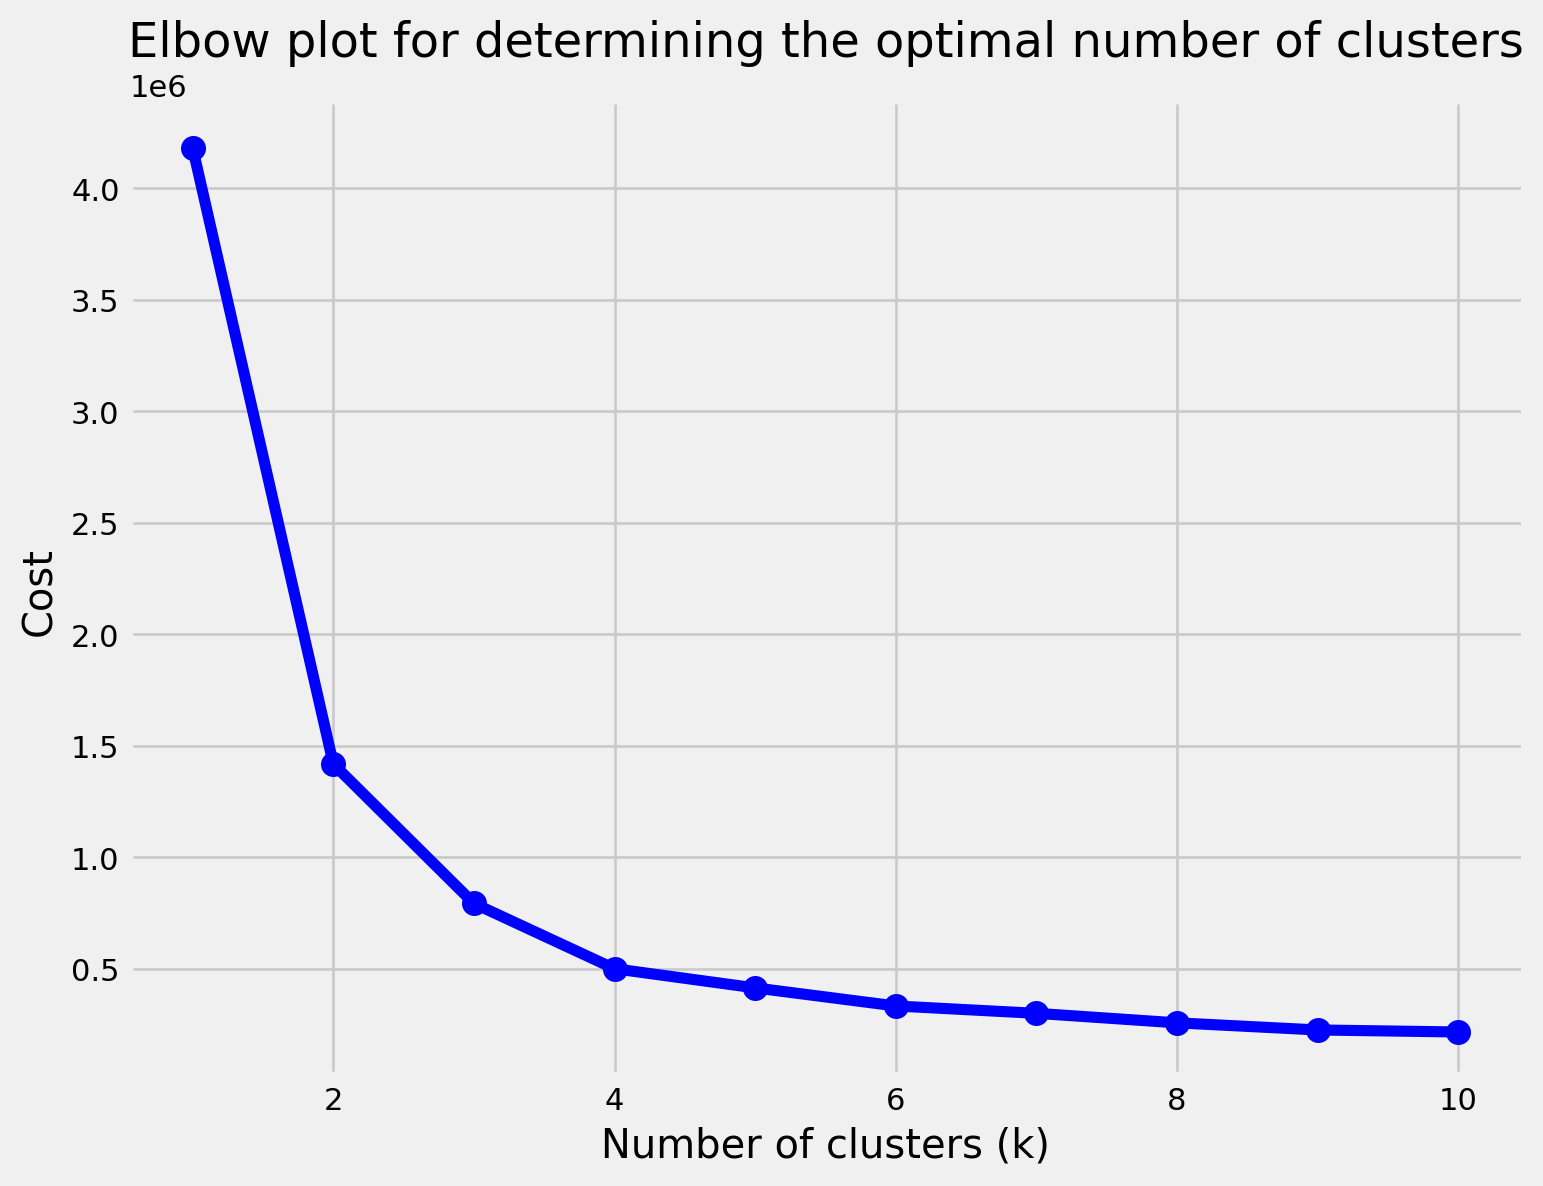

CPU times: user 7min 11s, sys: 26.7 s, total: 7min 37s
Wall time: 10min 47s


In [10]:
%%time

# clustering by new_car_price, brand and model
from kmodes.kprototypes import KPrototypes

proto_df = data[['brand', 'model', 'new_car_price_lakh']].copy()

for column in proto_df.select_dtypes(['object']).columns:
    proto_df[column] = proto_df[column].astype('category')

data_matrix = proto_df.to_numpy()

costs = []
K = range(1, 11)

for num_clusters in K:
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao', n_init=3, verbose=0, random_state=12345)
    kproto.fit_predict(data_matrix, categorical=[0, 1])
    costs.append(kproto.cost_)  

plt.figure(figsize=(8, 6))
plt.plot(K, costs, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow plot for determining the optimal number of clusters')
plt.grid(True)
plt.show()

In [11]:
%%time

# Optimal number of clusters is 4
proto = KPrototypes(n_clusters=4, init='Cao', n_init=3, verbose=0, random_state=12345)
proto_df['cluster'] = proto.fit_predict(data_matrix, categorical=[0, 1])

CPU times: user 33.4 s, sys: 2.1 s, total: 35.5 s
Wall time: 49.7 s


In [12]:
proto_df.groupby(['cluster'], observed=True).agg(
    min_price=('new_car_price_lakh', 'min'),
    median_price=('new_car_price_lakh', 'median'),
    max_price=('new_car_price_lakh', 'max')).sort_values(by='median_price')

,min_price,median_price,max_price
cluster,,,
3,3.6263,10.2197,26.2082
1,26.0715,41.8960,59.1200
0,58.9354,73.4982,115.9799
2,117.8793,160.0000,375.0000


Name car segments.

In [13]:
data['car_segment'] = proto_df['cluster'].replace({
                             3: 'Economy', 
                             1: 'Middle', 
                             0: 'Business', 
                             2: 'Luxury'})

In [14]:
data['car_segment'] = pd.Categorical(data['car_segment'],
                                    categories=['Economy', 'Middle', 'Business', 'Luxury'],
                                    ordered=True)
print('--- New Car Price, Lakh ---')
data.groupby(['car_segment'], observed=True).agg(
    min_price=('new_car_price_lakh', 'min'),
    median_price=('new_car_price_lakh', 'median'),
    max_price=('new_car_price_lakh', 'max')).sort_values(by='median_price')

--- New Car Price, Lakh ---


,min_price,median_price,max_price
car_segment,,,
Economy,3.6263,10.2197,26.2082
Middle,26.0715,41.8960,59.1200
Business,58.9354,73.4982,115.9799
Luxury,117.8793,160.0000,375.0000


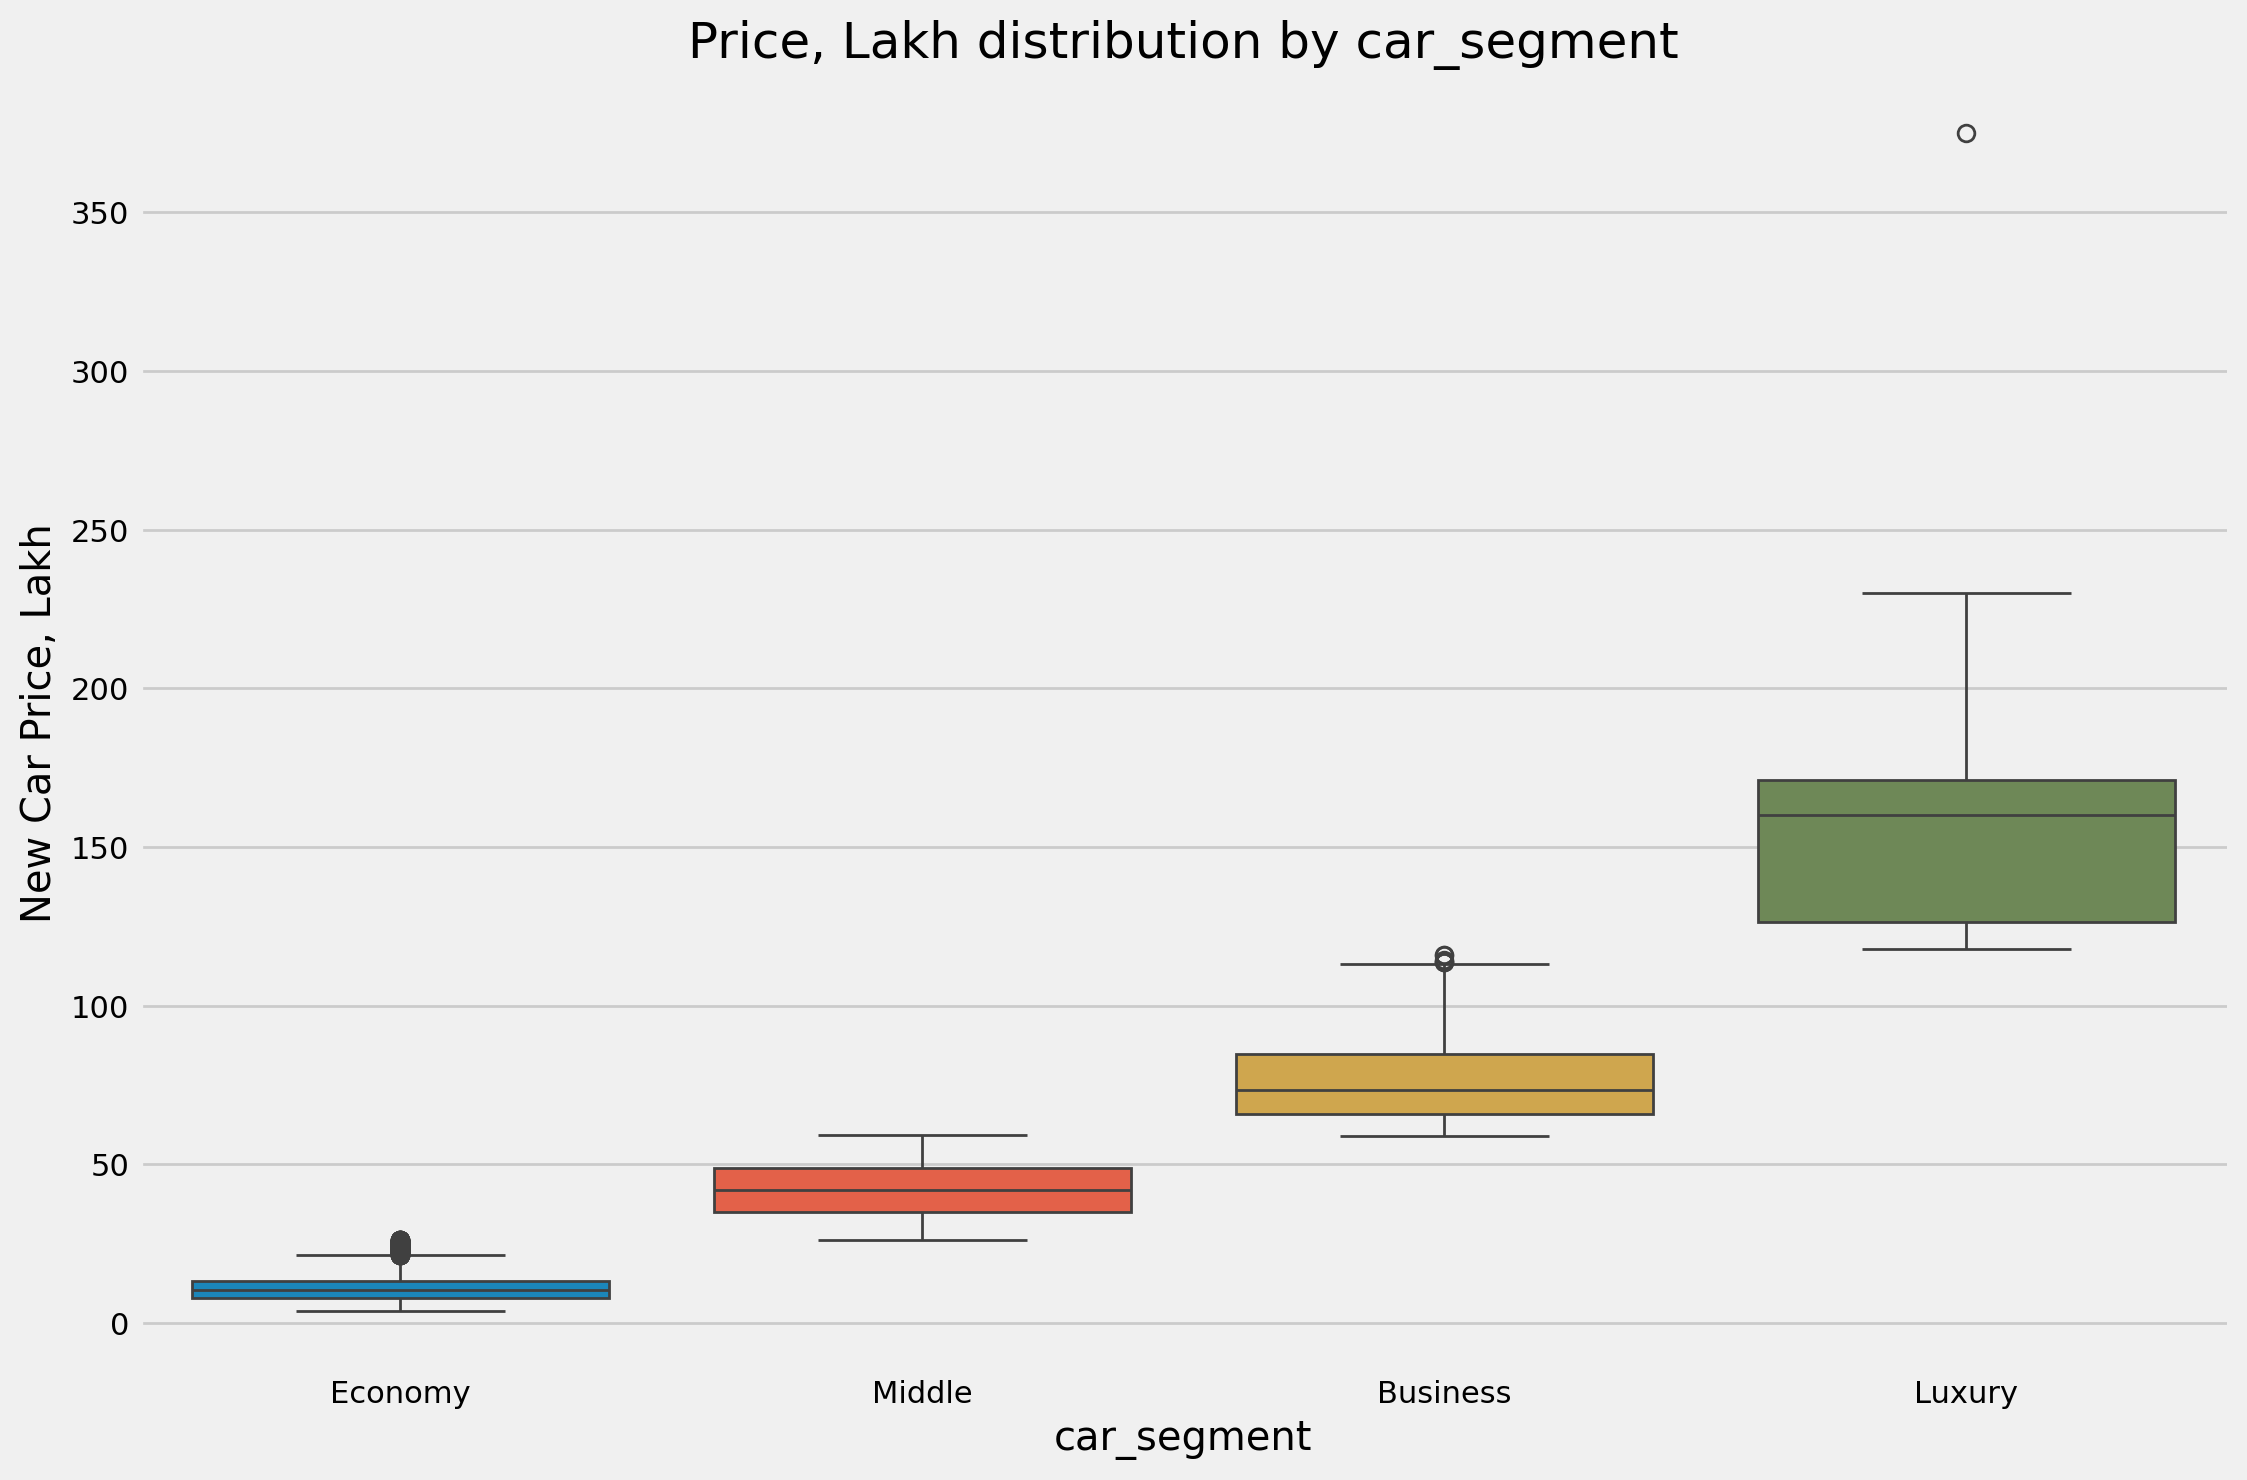

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='car_segment', y='new_car_price_lakh', data=data, hue='car_segment')
plt.title(f"Price, Lakh distribution by car_segment", fontsize=18)
plt.ylabel('New Car Price, Lakh')
plt.show()

In [16]:
data.groupby(['car_segment'], observed=True)[['brand', 'model']].size()

car_segment
Economy     5775
Middle       935
Business     477
Luxury        65
dtype: int64

### Data Transformation <a name='data-transformation'></a>

In [17]:
# Transform skewed data
skewed = data.select_dtypes(['number']).apply('skew')
skewed[(skewed > 2.0) | (skewed < -2)].index

Index(['kilometers_driven', 'price_lakh', 'new_car_price_lakh',
       'previous_owners'],
      dtype='object')

__Observations:__
- `kilometers_driven`, `price_lakh` and `new_car_price_lakh` are highly skewed which have to be transformed.

kilometers_driven
Skew: 3.83


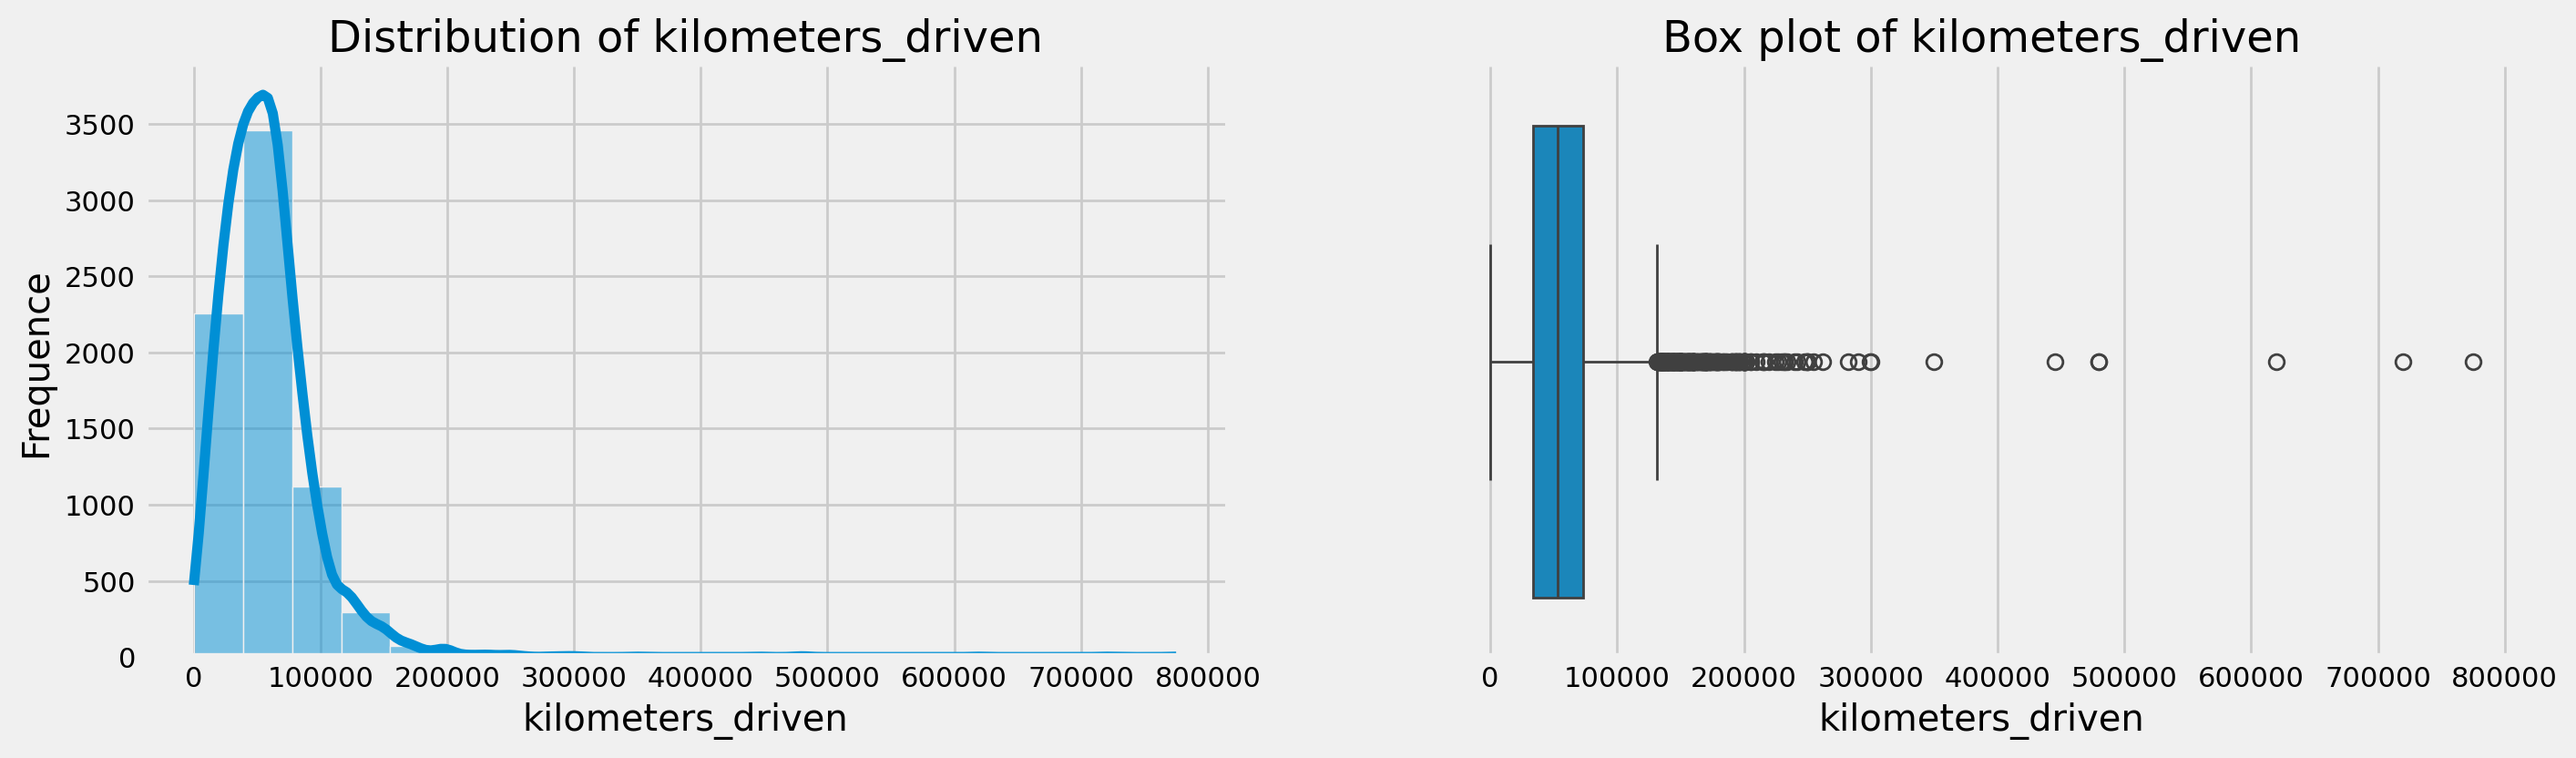

price_lakh
Skew: 3.34


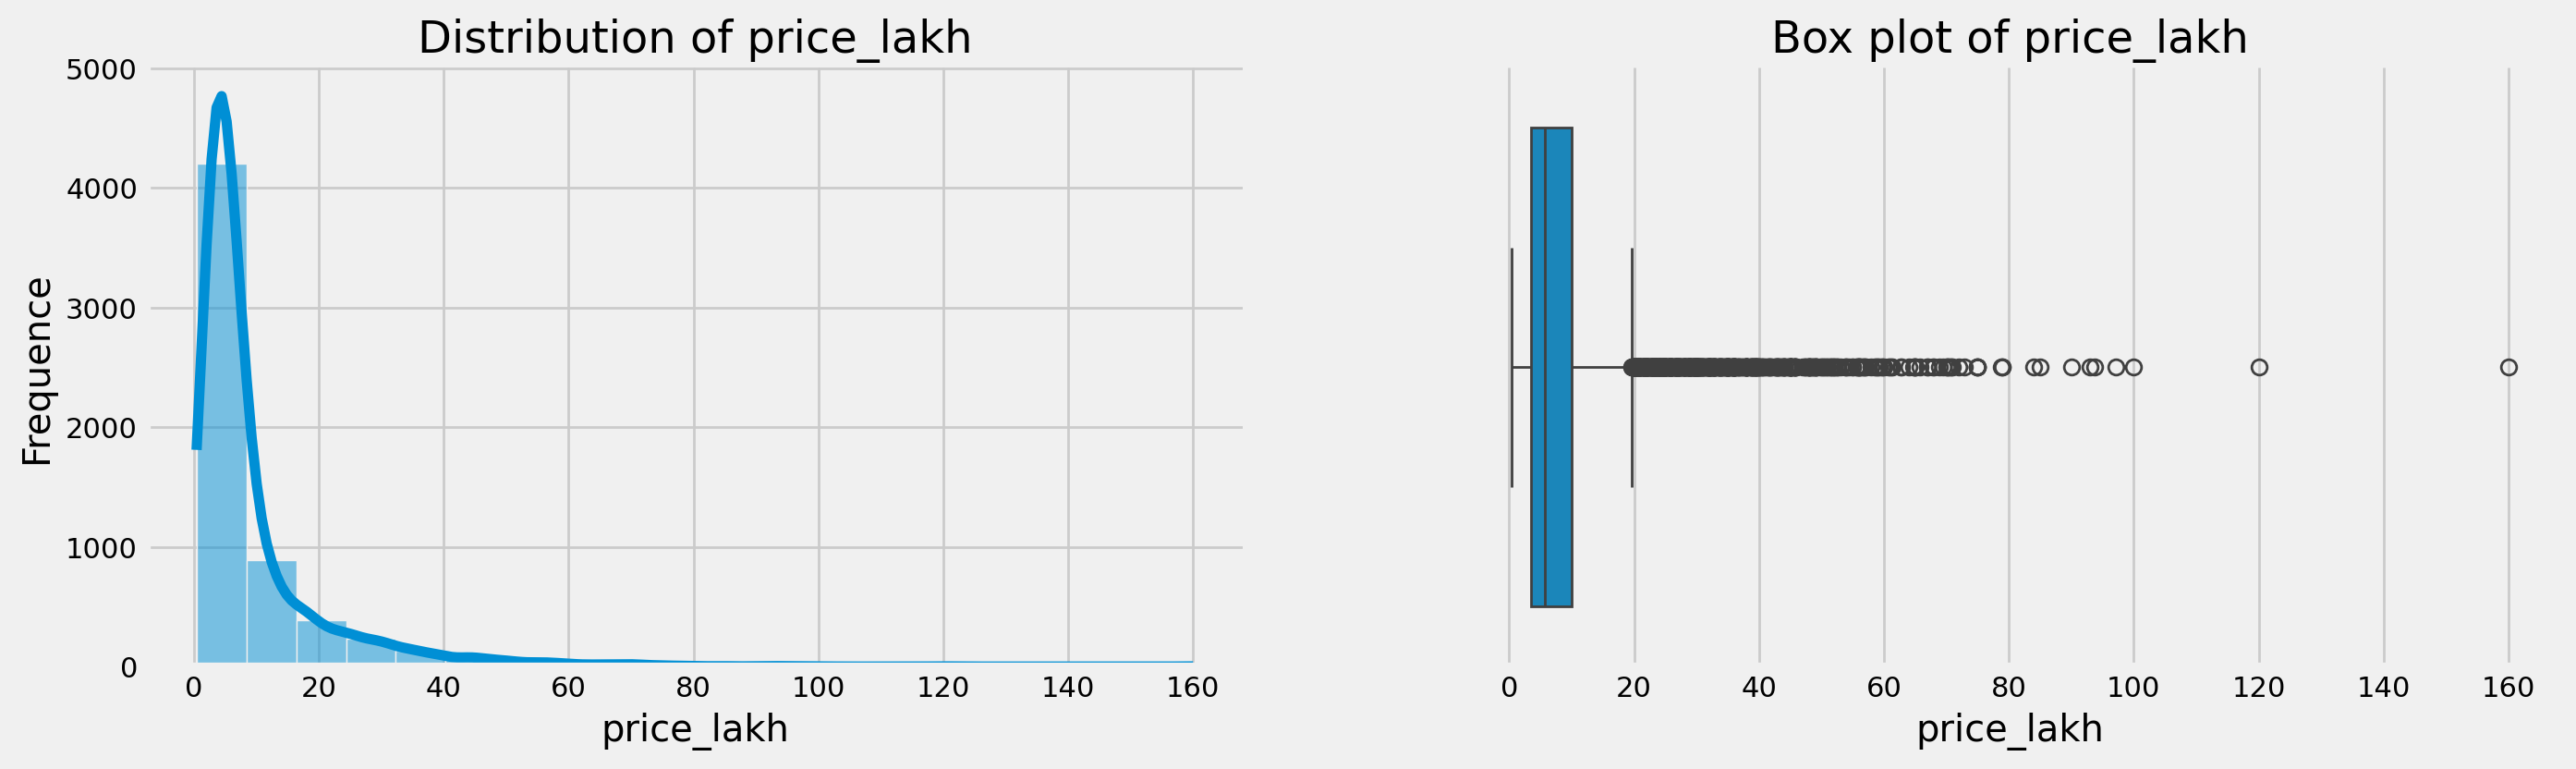

new_car_price_lakh
Skew: 3.4


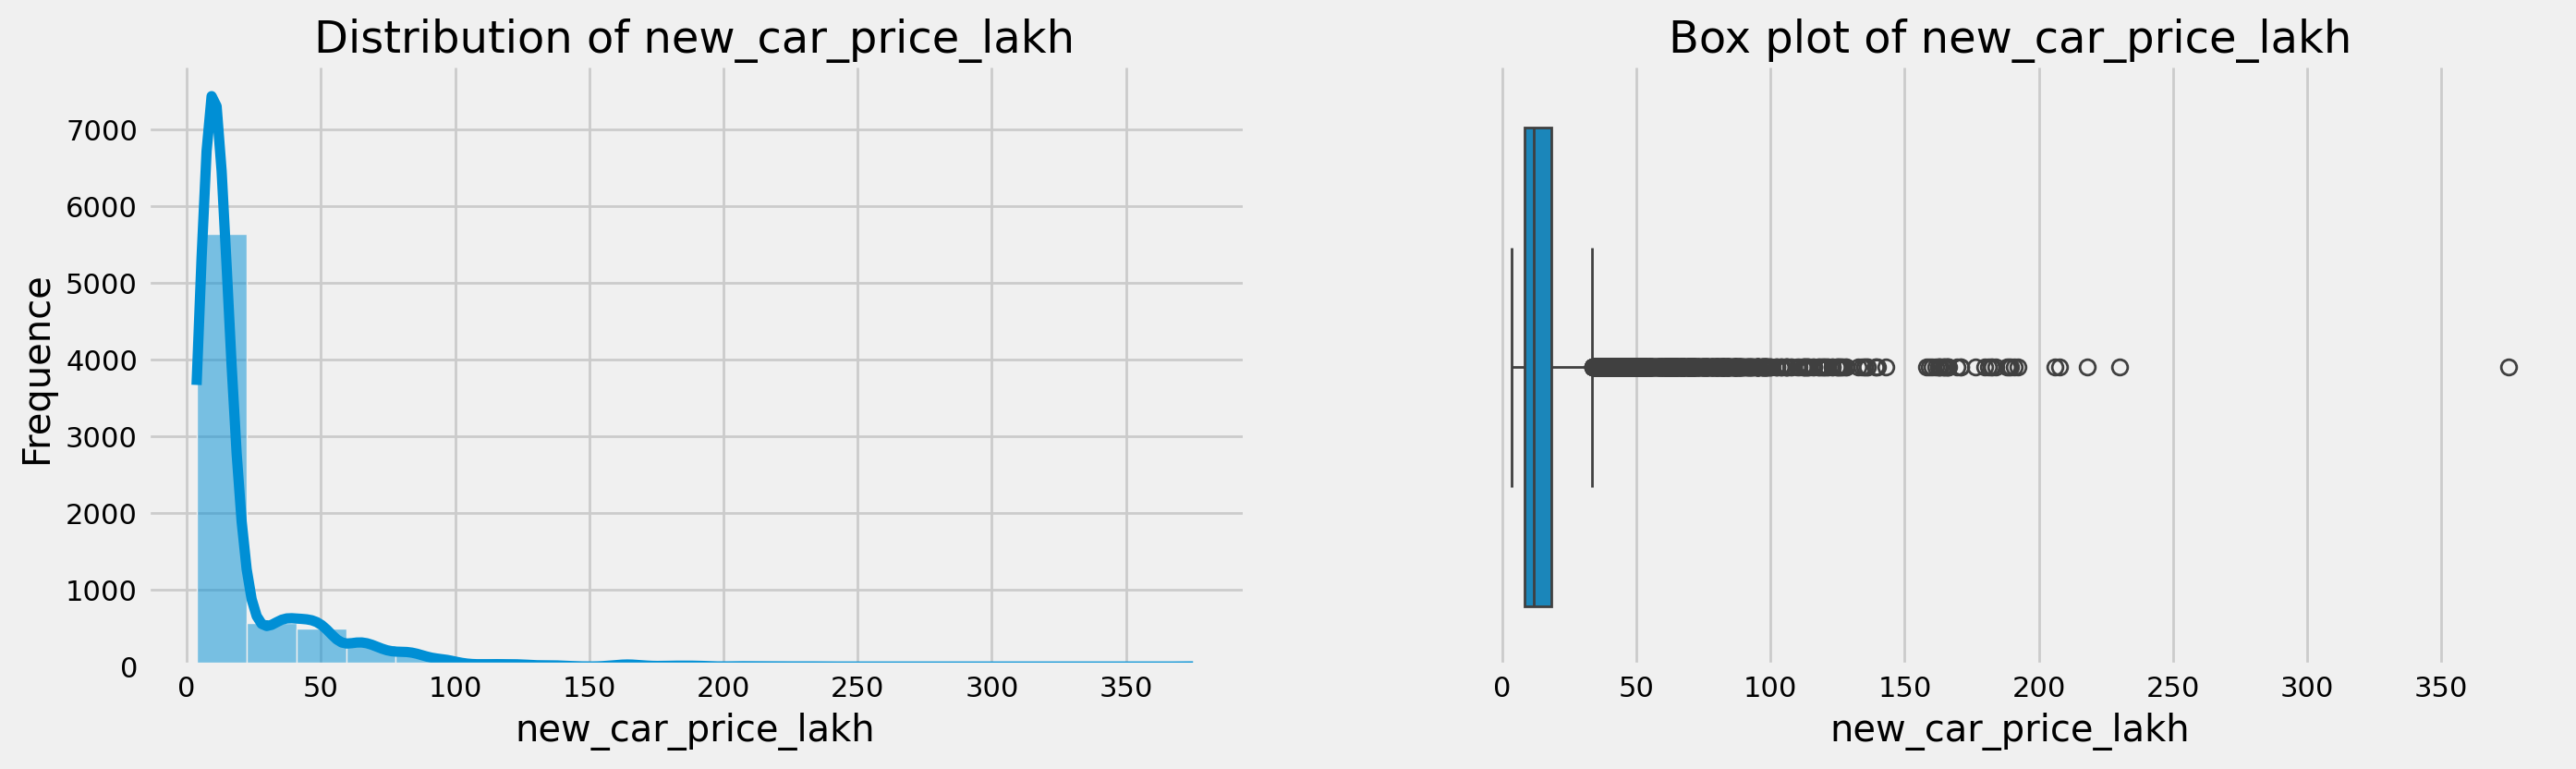

In [18]:
for col in ['kilometers_driven', 'price_lakh', 'new_car_price_lakh']:
    print(col)
    print(f'Skew: {round(data[col].skew(), 2)}')
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, bins=20)
    plt.ylabel('Frequence')
    plt.xlabel(col)
    plt.title(f'Distribution of {col}')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.title(f'Box plot of {col}')
    plt.show()

kilometers_driven
Skew: 1.34


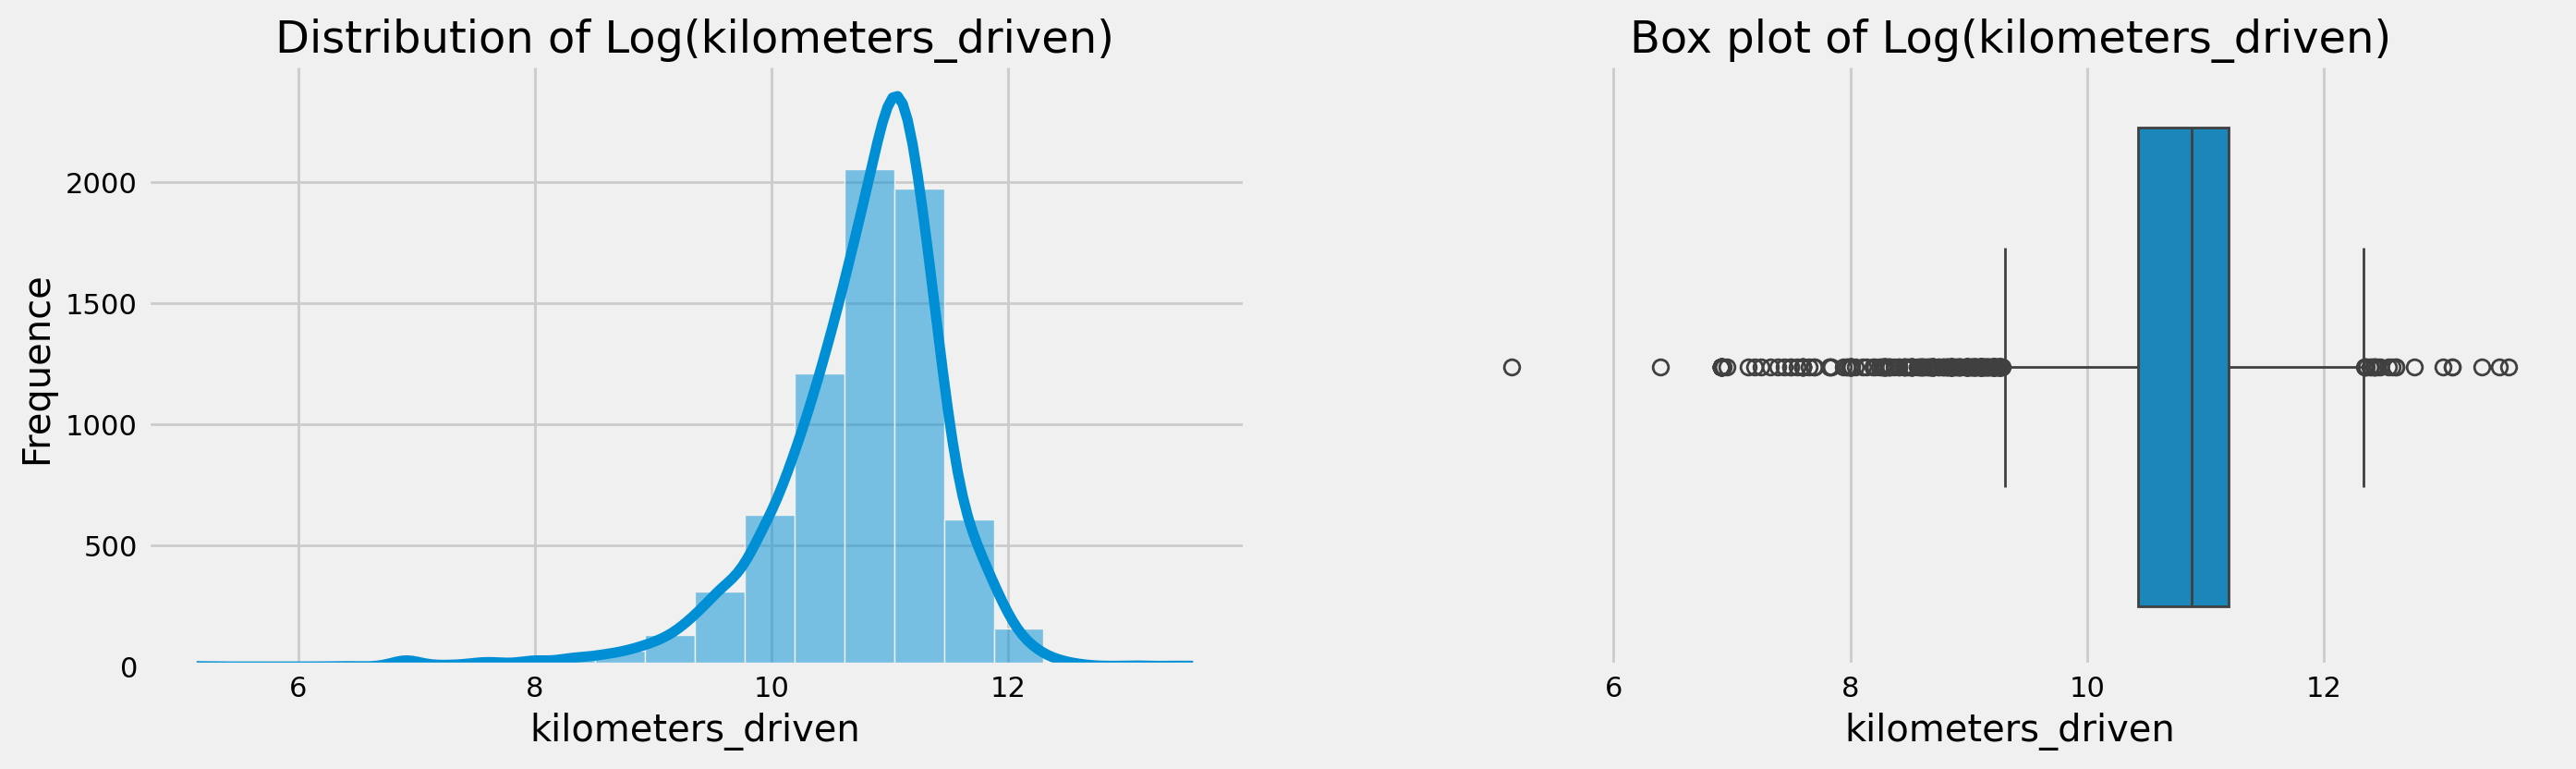

price_lakh
Skew: 1.2


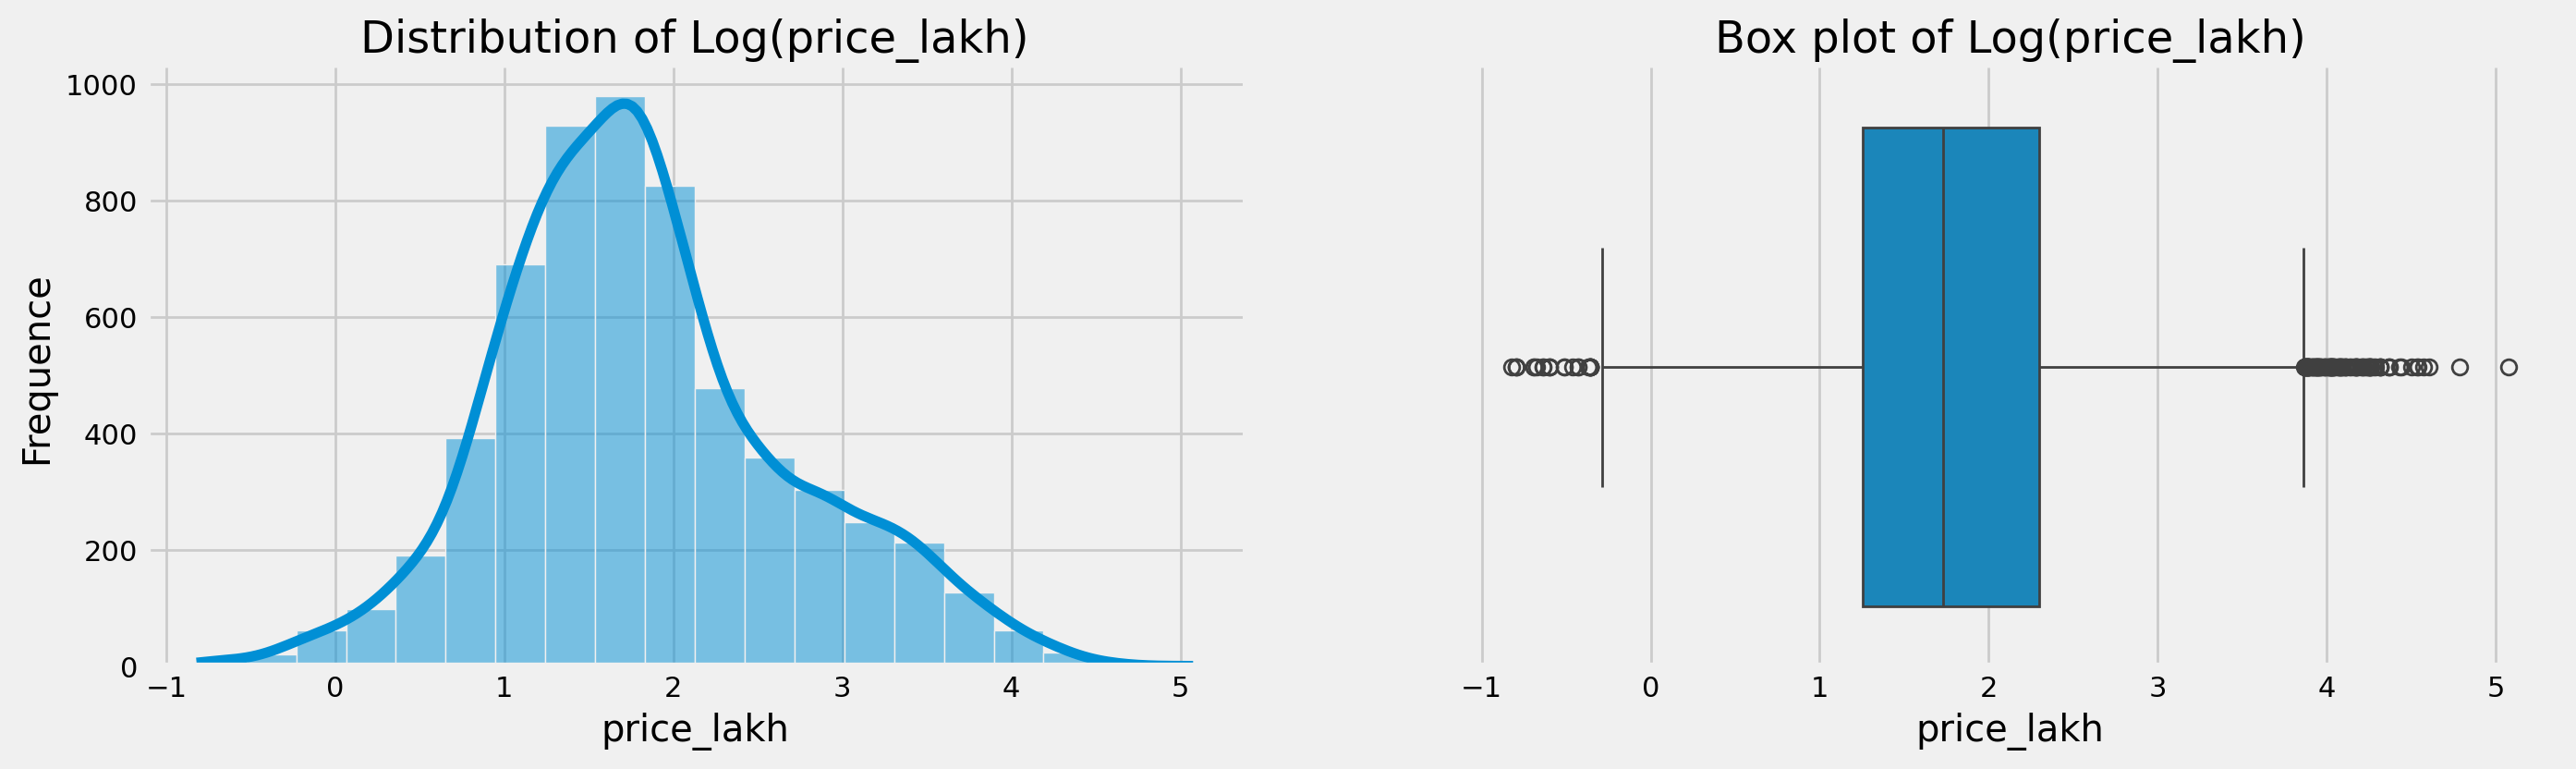

new_car_price_lakh
Skew: 1.22


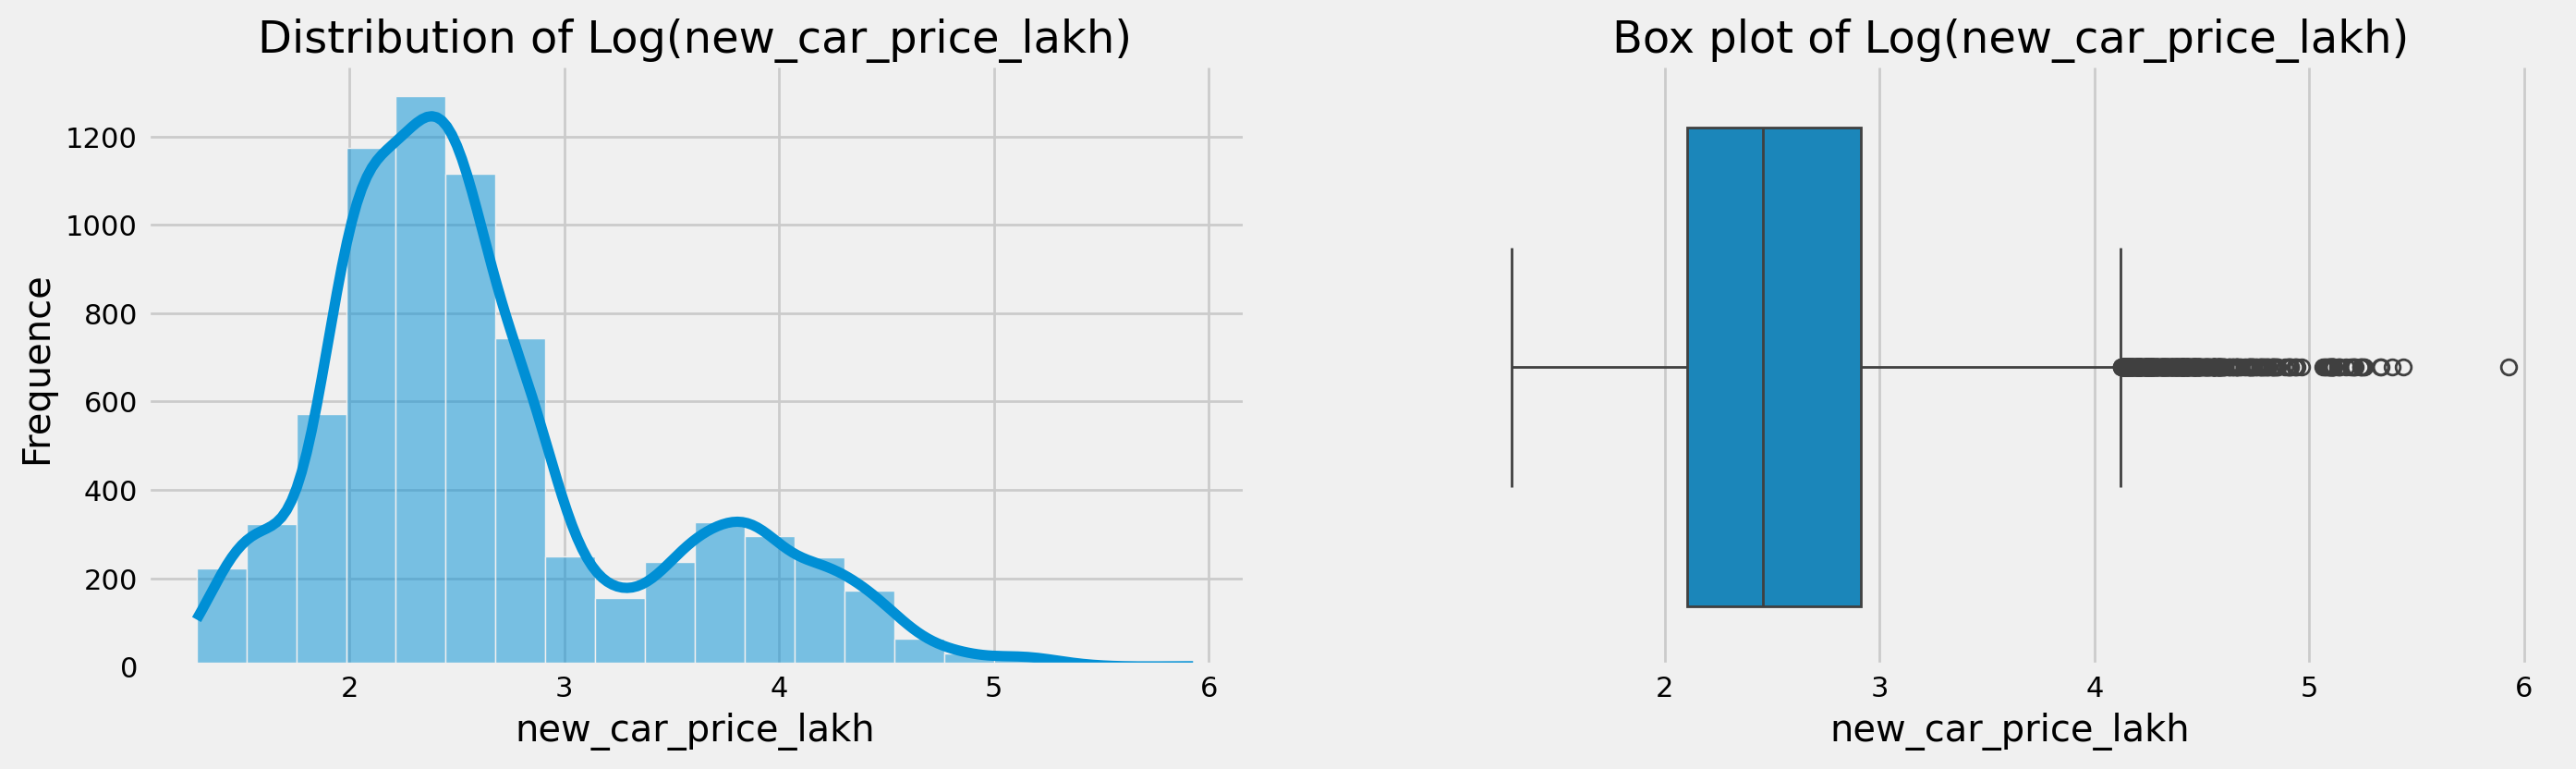

In [19]:
# check log(X)
for col in ['kilometers_driven', 'price_lakh', 'new_car_price_lakh']:
    print(col)
    print(f'Skew: {round(np.log(data[col].skew()), 2)}')
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(np.log(data[col]), kde=True, bins=20)
    plt.ylabel('Frequence')
    plt.xlabel(col)
    plt.title(f'Distribution of Log({col})')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=np.log(data[col]))
    plt.title(f'Box plot of Log({col})')
    plt.show()

In [20]:
# TODO: Apply log (Ln(X)) transformation for ['kilometers_driven', 'price_lakh', 'new_car_price_lakh']
for col in ['kilometers_driven', 'price_lakh', 'new_car_price_lakh']:
    data[f'{col}_log'] = np.log(data[col])

data.columns

Index(['location', 'year', 'kilometers_driven', 'fuel_type', 'transmission',
       'owner_type', 'engine_cc', 'power_bhp', 'seats', 'price_lakh', 'brand',
       'model', 'mileage_kmpl', 'new_car_price_lakh', 'previous_owners',
       'car_age', 'car_segment', 'kilometers_driven_log', 'price_lakh_log',
       'new_car_price_lakh_log'],
      dtype='object')

In [21]:
# drop Electric cars such as fuel_type is imbalanced
data.drop(data[data['fuel_type'] == 'Electric'].index, inplace=True)

In [22]:
data['fuel_type'] = data['fuel_type'].cat.remove_unused_categories()

## Save the Data <a name='save-data'></a>

In [23]:
# save processed dataset for modeling

filename = '../00_data/02_processed/used_cars_data_processed_final.pkl'
pickle.dump(data, open(filename, 'wb'))


---
\
[__<< Exploratory Data Analysis__](./03_Cars4u_exploratory_data_analysis.ipynb) | [__Home__](../README.md) | [__Modeling >>__](./05_Cars4u_modeling.ipynb)

\
\
Cars4u: Car Price Prediction, _August 2024_